In [1]:
%pylab inline
rc('animation', html='html5')
import mizer

Populating the interactive namespace from numpy and matplotlib


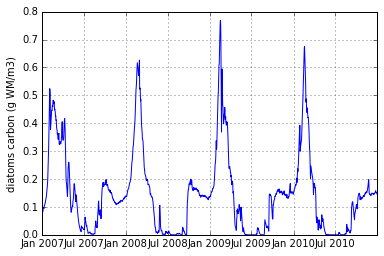

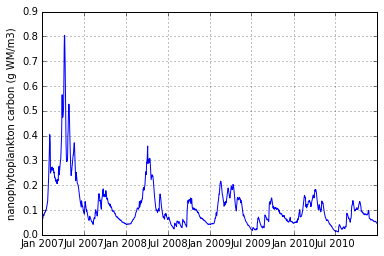

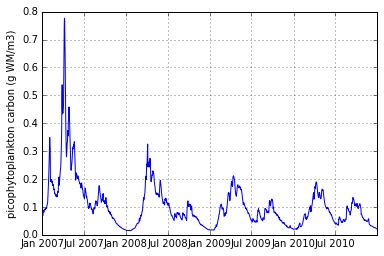

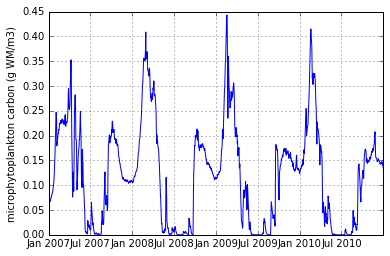

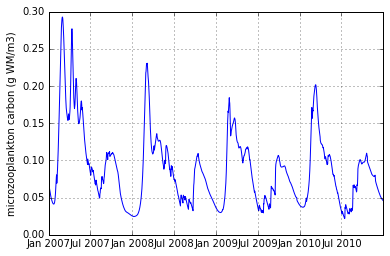

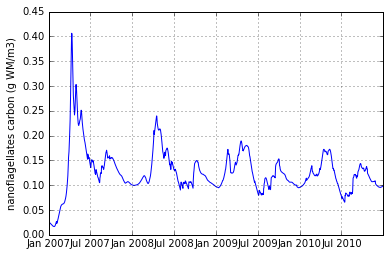

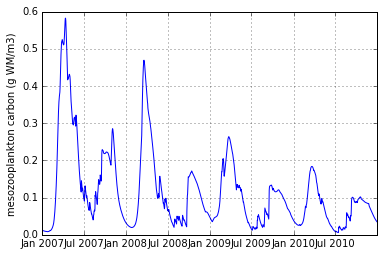

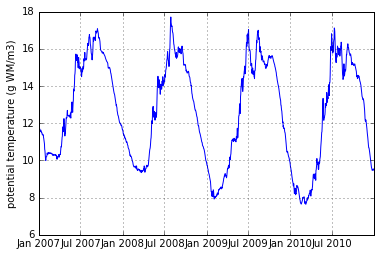

In [2]:
def esd2mass(d): # equivalent spherical diameter in micrometer
    V = 4./3.*pi*(d/2e6)**3  # volume in m3
    return V*1e6  # mass in g approximately equals volume in m3 multiplied by 1e6
path = r'C:\Users\Jorn\Documents\ssb-ersem-git\testcases\ersem_gotm\L4\output\fabm_ref.nc'
scale_factor = 0.01 # 10 g wet mass/g carbon * 0.001 g C/mg C
diatoms = mizer.Prey('diatoms', 1.5e-7, mizer.datasources.TimeSeries(path, 'P1_c', z=-1, scale_factor=scale_factor))
nanophy = mizer.Prey('nanophy', 1.7e-11, mizer.datasources.TimeSeries(path, 'P2_c', z=-1, scale_factor=scale_factor))
picophy = mizer.Prey('picophy', 1e-12, mizer.datasources.TimeSeries(path, 'P3_c', z=-1, scale_factor=scale_factor))
microphy = mizer.Prey('microphy', 1.5e-7, mizer.datasources.TimeSeries(path, 'P4_c', z=-1, scale_factor=scale_factor))
microzoo = mizer.Prey('microzoo', 1e-5, mizer.datasources.TimeSeries(path, 'Z5_c', z=-1, scale_factor=scale_factor))
nanoflag = mizer.Prey('nanoflag', 1e-6, mizer.datasources.TimeSeries(path, 'Z6_c', z=-1, scale_factor=scale_factor))
mesozoo = mizer.Prey('mesozoo', 1e-4, mizer.datasources.TimeSeries(path, 'Z4_c', z=-1, scale_factor=scale_factor))
temp = mizer.datasources.TimeSeries(path, 'temp', z=-1)

In [3]:
m = mizer.Mizer(prey=(diatoms, nanophy, picophy, microphy, microzoo, nanoflag, mesozoo), parameters={'w_minF': 1.25, 'F': 1.6, 'recruitment': 10000}, temperature_provider=temp)
times = numpy.arange(datestr2num('2008-01-01'), datestr2num('2010-01-01'))
result = m.run(times, spinup=50, verbose=True)

number of size classes: 100 
number of prey: 7 
assimilation efficiency: 0.2 -
reproductive efficiency: 1.0 -
egg weight: 0.001 g
exponent of max. consumption: 0.666666666667 -
exponent of search volume: 0.82 -
exponent of standard metabolism: 0.7 -
type of background mortality (0: constant, 1: allometric function of size): 1 
pre-factor for background mortality: 0.1 yr-1
exponent of background mortality: -0.25 -
start weight for senescence mortality: 1000.0 g
exponent for senescence mortality: 0.3 -
maturation weight: 0.0 g
asymptotic weight: 1000000.0 g
preferred predator:prey mass ratio: 100.0 -
width of prey size preference (sd in ln weight units): 2.2 -
fraction of weight consisting of lipid reserve: 0.1 -
von Bertalanffy growth rate: 0.0 yr-1
exponent of background resource spectrum: 2.15333333333 -
carrying capacity of background resource spectrum: 1e+11 g^(lambda-1)
background feeding level: 0.6 -
stock-recruitment relationship (0: constant recruitment, 1: density-independent r

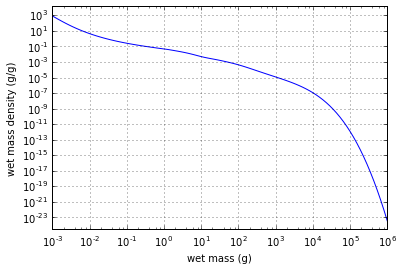

In [4]:
from ipywidgets import widgets
def show_spectrum(day):
    result.plot_spectrum(day, normalization=1, global_range=True)
slider = widgets.interact(show_spectrum, day=(0, len(times)-1))

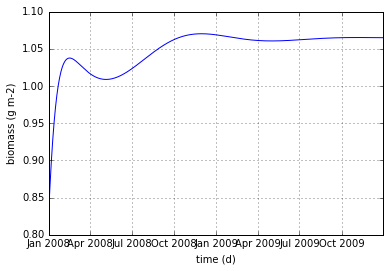

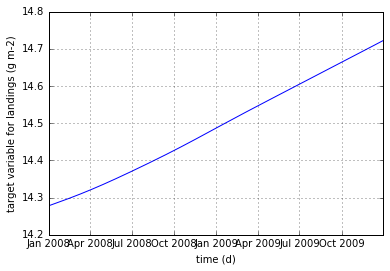

In [5]:
result.plot_biomass_timeseries()
result.plot_timeseries('landings')

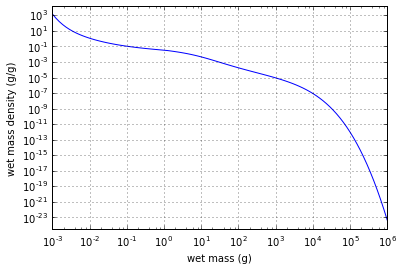

In [7]:
anim = result.animate_spectrum(normalization=1)

In [ ]:
anim

In [ ]:
esd2mass(200.)

In [ ]:
m.bin_masses